In [28]:
# Needed more computational power so moved to colab at least temporarily
import torch
import numpy as np
import matplotlib.pyplot as plt   
import pickle
import torch.nn.functional as F
import torch.nn as nn
import seaborn as sns 
import os
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [29]:
device

device(type='cuda')

In [30]:
# Hyperparams
n_epochs = 5
batch_size = 128
lr = 1e-3
train_log = []
val_log = {}
k = 0
best_nll = np.inf

In [31]:
# Loading data
pickle_file = 'C:/Users/Johan/Downloads/mnist-hw1.pkl'
#path = '/content/drive/My Drive/mnist-hw1.pkl'
mnist = pickle.load(open(pickle_file,'rb'))

X_train = mnist['train'][:20000].astype('float32')
train_loader = torch.utils.data.DataLoader(torch.from_numpy(X_train), batch_size=batch_size, shuffle=True)

X_val = mnist['test'][:2000].astype('float32')
val_loader = torch.utils.data.DataLoader(torch.from_numpy(X_val), batch_size=batch_size, shuffle=True)

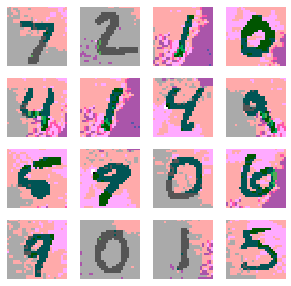

In [32]:
fig, ax = plt.subplots(4,4,figsize=(5,5))
for i in range(4):
    for j in range(4):
        ax[i,j].imshow(X_val[4*i+j]/3)
        ax[i,j].axis('off')

In [33]:
class MaskedConv2d(nn.Conv2d):
    """ Masked Conv2d spatial mask only."""
    
    #args and kwargs take undefined input args
    def __init__(self,mask_type='A', *args, **kwargs):
        super(MaskedConv2d,self).__init__(*args, **kwargs)
        
        assert mask_type in {'A', 'B'}
        
        mask = torch.ones_like(self.weight)
        _, _, height, width = self.weight.shape
        
        #Spatial masking
        mask[:, :, height // 2, width // 2 + (mask_type == 'B'):] = 0 
        mask[:, :, height // 2 + 1:] = 0
        self.register_buffer('mask',mask)
        
    def forward(self,x):
        self.weight.data = self.weight.data.mul(self.mask) #inplace operation is faster
        return super(MaskedConv2d, self).forward(x)

In [34]:
class ResNetBlock(nn.Module):
    """According to PixelCNN paper article 1 figure 5 and table 1
    https://arxiv.org/pdf/1601.06759.pdf
    """

    def __init__(self,in_channels):
        super(ResNetBlock,self).__init__()

        self.h = in_channels//2
        self.out = nn.Sequential(
            nn.ReLU(), #Relu first, strange setup
            nn.Conv2d(in_channels,self.h,kernel_size=1),
            nn.ReLU(),
            # padding to conserve shape.
            MaskedConv2d(in_channels=self.h,out_channels=self.h,kernel_size=3,padding=1,mask_type='B'),
            nn.ReLU(),
            nn.Conv2d(self.h,in_channels,kernel_size=1)
        )

    def forward(self,x):
        return self.out(x) + x

In [35]:
class PixelCNN(nn.Module):

    def __init__(self,n_layers=12, n_filters=128,n_classes=4,final_channels=3):
        # 4 channels due to two bits per dim.
        super(PixelCNN,self).__init__()
        
        self.n_classes = n_classes
        self.final_channels = final_channels
        
        #padding=3 so it can start in [0,0], otherwise it has to start inside the image.
        layers = [MaskedConv2d(in_channels=3,out_channels=n_filters,kernel_size=7,padding=3,mask_type='A')]

        for i in range(n_layers):
            layers.append(ResNetBlock(n_filters))

        # PixelCNN paper uses 1024 for colored data
        layers += [nn.ReLU()] + \
                [MaskedConv2d(in_channels=n_filters,out_channels=1024,kernel_size=1,mask_type='B')] +\
                [nn.ReLU()] +\
                [MaskedConv2d(in_channels=1024,out_channels=final_channels*n_classes,kernel_size=1,mask_type='B')]

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = self.layers(x)
        logits = x.view([x.shape[0], self.n_classes, self.final_channels, x.shape[2], x.shape[3]])
        out = F.softmax(logits, dim=1)  # [N, n_classes, C, H, W]
        return logits, out

    def _sample(self, n_samples=1):
        samples = torch.Tensor(np.random.choice(4, size=(n_samples, 28, 28, 3)))

        for i in range(28):
            for j in range(28):
                out = self(samples)
                intensity = torch.distributions.Categorical(out).sample()
                samples[:, i, j, :] = intensity[:, i, j, :]

        return samples

In [36]:
net = PixelCNN().to(device)
optimizer = optim.Adam(net.parameters(),lr=lr)

In [37]:
def calc_loss(logits, batch):
    # Divide by 2 for NLL per bit
    #print(logits.shape,batch.shape)
    loss = F.cross_entropy(logits, batch.long(), reduction='sum') / batch_size 
    return loss

In [38]:
# Training loop
for epoch in range(n_epochs):
    for mini_batch in train_loader:
        # https://jdhao.github.io/2019/07/10/pytorch_view_reshape_transpose_permute/
        mini_batch = mini_batch.permute(0,3,1,2).to(device) #To save memory we send one batch to cuda at the time
        logits,dist = net(mini_batch)
        loss = calc_loss(logits,mini_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_log.append(loss.item())
        k += 1

    with torch.no_grad():
        logits,dist = net(X_val.permute(0,3,1,2).to(device))
        loss = calc_loss(logits,mini_batch)
        val_log[k] = loss.item()

    if loss.item() < best_nll:
        best_nll = loss.item()
        save_checkpoint({'epoch': epoch,
                         'state_dict': net.state_dict()}, save_dir)

    print('[Epoch %d/%d][Step: %d] Train Loss: %s Test Loss: %s' \
          % (epoch, n_epochs, k, np.mean(train_log[-10:]), val_log[k]))

torch.Size([128, 4, 3, 28, 28]) torch.Size([128, 3, 28, 28])
torch.Size([128, 4, 3, 28, 28]) torch.Size([128, 3, 28, 28])
torch.Size([128, 4, 3, 28, 28]) torch.Size([128, 3, 28, 28])
torch.Size([128, 4, 3, 28, 28]) torch.Size([128, 3, 28, 28])
torch.Size([128, 4, 3, 28, 28]) torch.Size([128, 3, 28, 28])
torch.Size([128, 4, 3, 28, 28]) torch.Size([128, 3, 28, 28])
torch.Size([128, 4, 3, 28, 28]) torch.Size([128, 3, 28, 28])
torch.Size([128, 4, 3, 28, 28]) torch.Size([128, 3, 28, 28])
torch.Size([128, 4, 3, 28, 28]) torch.Size([128, 3, 28, 28])
torch.Size([128, 4, 3, 28, 28]) torch.Size([128, 3, 28, 28])
torch.Size([128, 4, 3, 28, 28]) torch.Size([128, 3, 28, 28])
torch.Size([128, 4, 3, 28, 28]) torch.Size([128, 3, 28, 28])
torch.Size([128, 4, 3, 28, 28]) torch.Size([128, 3, 28, 28])
torch.Size([128, 4, 3, 28, 28]) torch.Size([128, 3, 28, 28])
torch.Size([128, 4, 3, 28, 28]) torch.Size([128, 3, 28, 28])
torch.Size([128, 4, 3, 28, 28]) torch.Size([128, 3, 28, 28])
torch.Size([128, 4, 3, 2

KeyboardInterrupt: 

In [ ]:
mini_batch.clone().long().view(-1)

In [ ]:
logits.shape